In [1]:
# !pip install -q datasets transformers
#!pip install accelerate -U

In [2]:
import datasets

dataset = datasets.load_dataset('cifar10', split='train', ignore_verifications=False)
dataset

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2555: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=all_checks' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

In [3]:
dataset_test = datasets.load_dataset('cifar10', split='test', ignore_verifications=False)
dataset_test

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2555: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=all_checks' instead.
  warnings.warn(


Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})

In [4]:
num_classes = len(set(dataset['label']))
labels = dataset.features['label']
labels

ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)

airplane


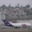

In [5]:
print(labels.names[dataset[0]['label']])
dataset[0]['img']

In [6]:
from transformers import ViTFeatureExtractor

model_id = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor(model_id)
feature_extractor

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": "google/vit-base-patch16-224-in21k",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [7]:
example = feature_extractor(dataset[0]['img'])
print(example.keys())
len(example['pixel_values'])
example['pixel_values'][0].shape

dict_keys(['pixel_values'])


(3, 224, 224)

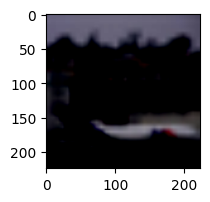

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure', figsize=(4, 2))

plt.imshow(example['pixel_values'][0].transpose(1, 2, 0));

In [9]:
import torch

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('device', device)

device cuda:0


In [10]:
def preprocess(batch):
    inputs = feature_extractor(batch['img'], return_tensors='pt')
    inputs['label'] = batch['label']
    return inputs

In [11]:
prepared_train = dataset.with_transform(preprocess)
prepared_test = dataset_test.with_transform(preprocess)

In [12]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([ele['pixel_values'] for ele in batch]),
        'labels': torch.tensor([ele['label'] for ele in batch]),
    }

In [19]:
from datasets import load_metric
import numpy as np
metric = load_metric('accuracy')
def compute_metrics(p):
    return metric.compute(
        prediction = np.argmax(p.predictions, axis=1),
        references = p.label_ids
    )

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [20]:
from transformers import TrainingArguments
import torch
torch.cuda.empty_cache()

training_args = TrainingArguments(
    output_dir='./cifar',
    per_device_train_batch_size=16,
    evaluation_strategy='steps',
    num_train_epochs=1,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True
)

In [21]:
from transformers import ViTForImageClassification
labels = dataset.features['label'].names
model = ViTForImageClassification.from_pretrained(model_id, num_labels=len(labels)).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=feature_extractor
)

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics('train', train_results.metrics)
trainer.save_metrics('train', train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss


In [ ]:
metrics = trainer.evaluate(prepared_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

In [ ]:
img = dataset_test['img'][0].resize((200, 200))
img

In [ ]:
act_label = dataset_test['label'][0]
labels = dataset_test.features['label']
act_label, labels.names[act_label]

In [ ]:
from transformers import ViTForImageClassification, ViTFeatureExtractor
model_name_or_path = 'LaCarnevali/vit-cifar10'
model_finetuned = ViTForImageClassification.from_pretrained(model_name_or_path)
feature_extractor_finetuned = ViTFeatureExtractor.from_pretrained(model_name_or_path)

In [ ]:
inputs = feature_extractor_finetuned(img, return_tensors='pt')
with torch.no_grad():
  logits = model_finetuned(**inputs).logits

In [ ]:
pred_label = logits.argmax(-1).item()
labels = dataset_test.features['label']
labels.names[pred_label]